# Ridge Rigression

This notebook implements an implementation of the Ridge Rigression. The implementation of the Ridge Regression has two different forms. Once with `normal equation` and once with `Gradient Descent`.

### Theory

The cost-function for Ridge Regression looks as follows. This term looks alike the cost-function of simple Linear Regression, but has one additional term, which is related to the model paramters $\beta$. if we optimize this cost objective the parameters will automatically penalized by this term $\alpha\sum_{j=1}^{p} \beta_j^2$. Our model will shrink large coefficients depeding on the weight $\alpha$ which has to be defined at the initialization of the model.


\begin{equation}
J(\beta) = \frac{1}{2N}\sum_{i=1}^{N} (y^{(i)}-\beta_0 - \sum_{j=1}^{p} x^{(i)}_j\beta_j)^2 + \alpha\sum_{j=1}^{p} \beta_j^2 
\end{equation}

### Derivation of Cost-Function

#### Derivation of the cost-function w.r.t. $\beta_0$:

$$\frac{\partial J(\beta)}{\beta_0}= \frac{1}{N} \sum_{i=1}^{N} -1*(y^{(i)} - \beta_0 - \sum_{j=1}^{p} x^{(i)}_j\beta_j)$$

Important to mention here is that $\beta_0$ will not be regularized, so the L2-Regularization terms falls off the equation. This formula can also be rewritten in matrix-notation which will be much more helpful for the implementation:

$$\nabla J(\beta) = 
\frac{\partial J(\beta)}{\partial \beta_0} =
-\frac{1}{N}e^T(y-X\beta)$$

Here the vector $e \in R^{nx1}$ is a vector , which consists of 1's only.


#### Derivation of the cost-function w.r.t. $\beta_{1...n}$:

$$\nabla J(\beta) = 
\frac{\partial J(\beta)}{\partial \beta_0} = 
\frac{1}{N} \sum_{i=1}^{N}-x^{(i)}(y^{(i)} - \beta_0 - \sum_{j=1}^{p} x^{(i)}_j\beta_j) + 2\alpha\sum_{j=1}^{p} \beta_j$$

Here again we can rewrite the gradient in matrix notation. We end-up with following equation:

$$\nabla J(\beta) = 
\frac{\partial J(\beta)}{\partial \beta} =
-\frac{1}{N}X^T(y-X\beta)+2\alpha\beta$$


#### Normal Equation

if the term above without the normalization on a sample ($\frac{1}{N}$) is considered to be zero we have an equation which we can be solved. First we make the term a little bit simpler solving the term in brackets and remove the scalar of 2:

$$-2X^T(y-X\beta)+2\alpha\beta = 0 \longrightarrow
-2X^Ty + 2X^TX\beta + 2\alpha\beta = 0  \longrightarrow
-X^Ty + X^TX\beta + \alpha\beta = 0
$$

Next we solve the equation to $\beta$:

$$
X^TX\beta + \alpha\beta = X^Ty \longrightarrow
(X^TX+\alpha)\beta = X^Ty \longrightarrow
(X^TX+\alpha)^{-1}(X^TX+\alpha)\beta = (X^TX+\alpha)^{-1}X^Ty 
$$

Finally we end-up with this equation. As $\alpha$ can not multiplied like this we have to multiply it first with Identity-Matrix $I$ with same shaoe as parameters, where the first index is zero as we do not want to penalize $\beta_0$.

$$\beta = (X^TX+\alpha I)^{-1}X^Ty
$$

This equatio represents the `normal equation` of our Regression Model.

### Implementation

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt

In [5]:
X, y = load_boston(return_X_y=True)

In [285]:
from sklearn.base import BaseEstimator

class RidgeRegression(BaseEstimator):
    """Implementation of Ridge Regression with L2-Regularizaion"""
    
    def __init__(self, opt_method='gd', alpha=1., eta=0.0001, maxsteps=100, eps=0.00001):
        '''Implements a Ridge Regression estimator.
        
        Arguments
        ---------
        alpha:      Regularization proportionality factor. Larger values
                    correspond with stronger regularization.
                    
        opt_method: Optimization method to choose for the cost function.
                    Can be either 'gd' (Gradient Descent) or 'neq'.
                    
        maxsteps:   Maximum number of Gradient Descent steps to take.
        
        eps:        Epsilon, length of gradient to be reached with Gradient
                    Descent.
                    
        eta:        Fixed step lenght to take at each gradient descent
                    iteration.
        '''
        # parameters
        self.alpha = alpha
        self.opt_method = opt_method
        self.maxsteps = maxsteps
        self.eps = eps
        self.eta = eta
        # attributes
        # model coefficients
        self.beta_ = None
        # values of cost function along gradient descent iterations
        self.costs_ = []       
        
    def fit(self, X, y):
        '''
        Fits the model to the given data predictors X to a target y
        
        arguments:
        --------------
        X:         Training data X
        y:         Training Data y
        '''        
        if self.opt_method == 'neq':
            self.normalequation(X, y)  
        elif self.opt_method == 'gd':
            self.gradient_descent(X, y)
        else:
            raise Exception(f"Choose opt_method 'neq' or 'gd'. You've chosen {self.opt_method}")
        
        return self
        
    def gradient_descent(self, X, y):
        '''
        Computes the coefficients of the ridge regression cost function
        using gradient descent.
        
        
        arguments:
        --------------
        X:         Training data X
        y:         Training Data y
        '''
        X = np.hstack((np.ones(X.shape[0]).reshape(-1,1), X)) 

        # Set start parameter beta
        self.beta_ = np.random.uniform(size=(X.shape[1]))
        
        # Set start parameter to pass first iteration of while loop
        grad = np.ones(shape=(X.shape[1]))
        steps = 0
        while steps < self.maxsteps and np.linalg.norm(self.eta*grad) > self.eps:
            
            grad = self.gradient(beta=self.beta_, X=X, y=y, alpha=self.alpha)
            self.beta_ = self.beta_ - self.eta * grad
            self.costs_.append(self.costfunction(beta=self.beta_, X=X, y=y, alpha=self.alpha))
            
            steps += 1
            
        
    def normalequation(self , X, y):
        '''
        Computes the coefficients of the ridge regression cost function
        using the normalequation.
        
        
        arguments:
        --------------
        X:         Training data X
        y:         Training Data y
        
        '''      
        # Add additional Axis for beta 0 with ones only
        X = np.hstack((np.ones(X.shape[0]).reshape(-1,1), X)) 
        
        # Create Matrix for regulation term with first line zeros
        I = np.identity(X.shape[1]) 
        I[0, 0] = 0
        
        # Normalequation with regulation term
        self.beta_ = np.linalg.inv(X.T @ X + self.alpha * I) @ X.T @ y
                
                
    @staticmethod
    def gradient(beta, X, y, alpha):
        '''
        (array, array, array, float) --> array
        
        Computes and returns the gradient of the ridge regression cost function.
        
        
        arguments:
        --------------
        X:         Training data X
        y:         Training Data y
        alpha:     scalar factor for L2-regularization
        
        returns:
        ---------------
        gradient:  Calculated gradient of derived cost-objective
        
        gradient([1,2,3], X, y, 0.1)
        >>> [1.11,1.2]
        '''        
        y_pred = X @ beta
        
        # Gradient beta 0
        gradient_b0 = -1/X.shape[0] * np.ones(X.shape[0]).T @ y_pred
    
        # Gradient beta 1..n
        gradient = ((-1/X.shape[0]) * X.T) @ (y - y_pred) 
        # Make beta0 to 0 to not regulize
        beta[0] = 0
        # Add regulation term and replace beta0
        gradient = gradient + 2*alpha*beta 
        
        gradient[0] = gradient_b0
        
        return gradient
    
    @staticmethod 
    def costfunction(beta,X,y,alpha):
        '''
        (array, array, array, float) --> float
        
        Computes and returns the value of the ridge regression cost function.
        cost = (1/(2*n)) * sum((y - pred)**2)
        
        
        arguments:
        --------------
        beta:      Model parameters
        X:         Training data X
        y:         Training Data y
        alpha:     scalar factor for L2-regularization
        
        costfunction(beta, X, y, 1)
        >>> 34.31
        '''
        pred = X @ beta
        cost = (1/X.shape[0]) * np.sum((y - pred)**2) + alpha * np.sum(beta[1:]**2)
        
        return cost
    
    def predict(self, X):
        '''
        (array) --> array
        
        Computes the predictions of the current model.
        pred = X @ b
        
        
        arguments:
        --------------
        X:         Training data X

        
        model.predict(X)
        >>> [[1],[2],[3] ... [n]]
        '''
        X = np.hstack((np.ones(X.shape[0]).reshape(-1,1), X)) 

        return X @ self.beta_

    
    def score(self, X, y):
        '''
        (array, array) --> float
        
        Returns R^2 for given input/output data given the model
        coefficients.
        
        Formula: 1 - SST/SSR
        
        arguments:
        --------------        
        X:         Training data X
        
        y:         Train data y        
        
        model.score(X,y)
        >>> 0.91
        '''
        SSR = np.sum((y - self.predict(X))**2)
        SST = np.sum((y - np.mean(y))**2)
        
        return 1 - SSR/SST

In [192]:
from sklearn.linear_model import Ridge

In [195]:
model = Ridge(alpha=1)
model.fit(X[:,:3],y)
model.coef_

array([-2.13627228,  1.36475698, -2.84611616])

### Check

In [210]:
ridge = RidgeRegression(opt_method='neq', alpha=1)
ridge.fit(X[:,:3],y)
print(ridge.beta_)

[22.53280632 -2.13627228  1.36475698 -2.84611616]


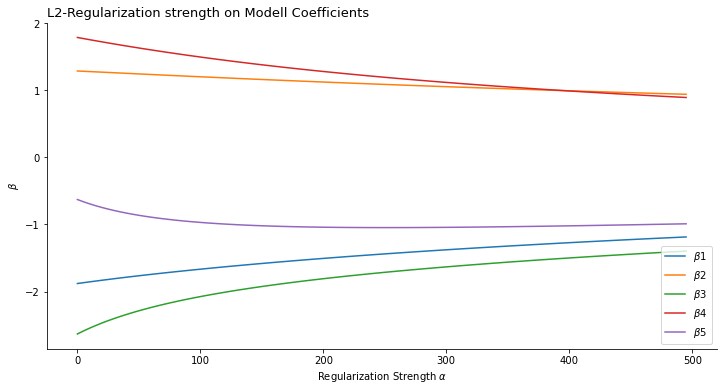

In [259]:
coefficients = {}
for a in range(0, 500, 5):
    ridge = RidgeRegression(opt_method='neq', alpha=a)
    ridge.fit(X[:,:5], y)
    coefficients[a] = ridge.beta_[1:]

fig = plt.subplots(figsize=(12, 6))
tmp = pd.DataFrame(coefficients)

for i in tmp.index.to_list():
    p = sns.lineplot(x=tmp.columns.to_list(), y=tmp.loc[i], label=r'$\beta$'+str(i+1))
    
sns.despine()
plt.ylabel(r'$\beta$')
plt.xlabel(r'Regularization Strength $\alpha$')
plt.title('L2-Regularization strength on Modell Coefficients', loc='left', fontsize=13)

plt.show()

In [283]:
ridge = RidgeRegression(opt_method='gd', alpha=10, eps=1e-7, eta=.01, maxsteps=10000)
ridge.fit(X[:,:3],y)
print(ridge.beta_[1:])

[-0.30505542  0.27691566 -0.37904603]


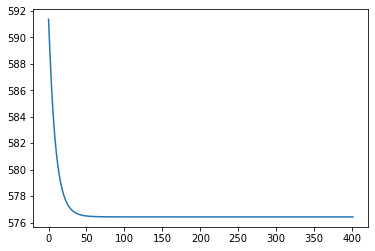

In [279]:
plt.plot(ridge.costs_)

In [278]:
model = Ridge(alpha=1)
model.fit(X[:,:3],y)
model.coef_

array([-2.13627228,  1.36475698, -2.84611616])

### Sources

pthesling (https://stats.stackexchange.com/users/64162/pthesling), How to derive the ridge regression solution?, URL (version: 2017-07-17): https://stats.stackexchange.com/q/164540

Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.